Si potrebbe pensare di utilizzare l'optical flow per migliorare il kamal flter

In [8]:
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import glob


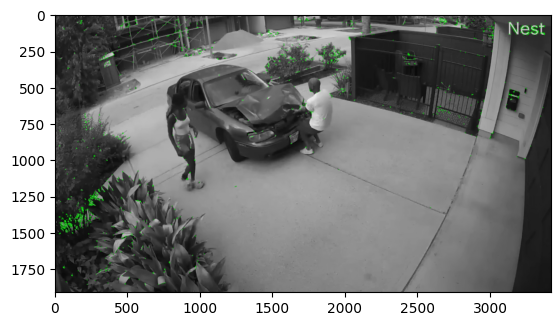

In [6]:
frames_dir = "preprocessed-frames"
# convert roi to grayscale, SIFT Algorithm works with grayscale images
image = cv2.imread(f"{frames_dir}/frame217.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Initialize the FAST detector and BRIEF descriptor extractor
fast = cv2.FastFeatureDetector_create(threshold=20)
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

# detect keypoints
keypoints_1 = fast.detect(gray, None)
# descriptors
keypoints_1, descriptors_1 = brief.compute(gray, keypoints_1)

# draw keypoints for visualizing
keypoints_image = cv2.drawKeypoints(gray, keypoints_1, outImage=None, color=(0, 255, 0))
# display keypoints
plt.imshow(keypoints_image,cmap="gray")

In [9]:
def load_grayscale_image(file_path):
    try:
        frame = cv2.imread(file_path)
        return cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    except Exception as e:
        print(f"Error loading image {file_path}: {e}")
        return None

In [11]:
# matcher object
bf = cv2.BFMatcher()

# Variables for FPS calculation
frame_count = 0
start_time = time.time()

for i in tqdm(range(1, len(glob.glob1(frames_dir, "*.jpg")) - 1)):
    #load the frame
    frame = load_grayscale_image(f"{frames_dir}/frame{i}.jpg")
    frame = cv2.resize(frame, (1366, 768) , interpolation= cv2.INTER_LINEAR)
    
    # Detect keypoints using FAST
    keypoints_2 = fast.detect(frame, None)

    # Compute descriptors using BRIEF
    keypoints_2, descriptors_2 = brief.compute(frame, keypoints_2)

    frame = load_grayscale_image(f"{frames_dir}/frame{i}.jpg")
    """
        Compare the keypoints/descriptors extracted from the 
        first frame(from target object) with those extracted from the current frame.
    """
    if descriptors_2 is  not None:
        matches =bf.match(descriptors_1, descriptors_2)
    
        for match in matches:
            
            # queryIdx gives keypoint index from target image
            query_idx = match.queryIdx
                
            # .trainIdx gives keypoint index from current frame 
            train_idx = match.trainIdx
                
            # take coordinates that matches
            pt1 = keypoints_1[query_idx].pt
                
            # current frame keypoints coordinates
            pt2 = keypoints_2[train_idx].pt
                
            # draw circle to pt2 coordinates , because pt2 gives current frame coordinates
            cv2.circle(frame,(int(pt2[0]),int(pt2[1])),5,(255,0,0),-1)
    
        # Calculate and display FPS
        frame_count += 1
        elapsed_time = time.time() - start_time
        fps = frame_count / elapsed_time
        cv2.putText(frame, f"FPS: {fps:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)


        cv2.imshow("coordinate_screen",frame) 
    
    
        k = cv2.waitKey(5) & 0xFF # after drawing rectangle press esc   
        if k == 27:
            cv2.destroyAllWindows()
            break
    else:
        break

cv2.destroyAllWindows()

 27%|██▋       | 205/748 [00:49<02:12,  4.10it/s]
